In [1]:
import os
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader  # Import Dataset and DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

BATCH_SIZE = 32
IMAGE_SIZE = (224,224)

In [2]:
train_dir = './train/train'
test_dir = './test/test'

def get_image_path(image_id, base_dir):
    for ext in ['.png', '.jpg']:
        file_path = os.path.join(base_dir, f"{image_id}{ext}")
        if os.path.isfile(file_path):  # Check if the file exists
            return file_path

train_images = pd.read_csv('train.csv')
train_images['file_path'] = train_images['id'].apply(lambda x: get_image_path(x, train_dir))

test_images = pd.read_csv('sample_submission.csv').drop(['jenis', 'warna'], axis=1)
test_images['file_path'] = test_images['id'].apply(lambda x: get_image_path(x, test_dir))

print(train_images.head())
print(test_images.head())

   id  jenis  warna            file_path
0   1      1      1  ./train/train/1.jpg
1   2      0      2  ./train/train/2.jpg
2   3      1      3  ./train/train/3.jpg
3   4      1      1  ./train/train/4.jpg
4   5      0      4  ./train/train/5.jpg
    id            file_path
0  778  ./test/test/778.png
1  779  ./test/test/779.jpg
2  780  ./test/test/780.jpg
3  781  ./test/test/781.jpg
4  782  ./test/test/782.jpg


In [3]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_images, test_size=0.2, random_state=42)  # 80% train, 20% val

In [4]:
from torchvision import transforms

# Define training data augmentations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),            # Resize to 224x224
    transforms.RandomHorizontalFlip(),        # Randomly flip image horizontally
    transforms.RandomRotation(15),            # Randomly rotate image by 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Randomly change brightness and contrast
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  # Normalize
])

# Validation transforms (no augmentations)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  # Normalize
])


In [5]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['file_path']
        binary_label = self.df.iloc[idx]['jenis']
        category_label = self.df.iloc[idx]['warna']
        image = Image.open(img_path).convert('RGB')  # Open image
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(binary_label, dtype=torch.float32), torch.tensor(category_label)


from torch.utils.data import DataLoader

# Create training and validation datasets
train_dataset = MultiLabelImageDataset(train_df, transform=train_transform)
val_dataset = MultiLabelImageDataset(val_df, transform=val_transform)

# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTModel
from torch.utils.data import DataLoader
from tqdm import tqdm


# Ensemble Multi-task Vision Transformer Model
class ViTEnsembleMultiTask(nn.Module):
    def __init__(self, num_category_labels, num_binary_labels=1, num_models=3):
        super(ViTEnsembleMultiTask, self).__init__()
        
        # Create a list of multiple ViT models for the ensemble
        self.num_models = num_models
        self.vit_models = nn.ModuleList([ViTModel.from_pretrained('google/vit-base-patch16-224-in21k') for _ in range(num_models)])
        self.hidden_size = self.vit_models[0].config.hidden_size
        
        # Separate classifiers for binary classification and multi-class classification
        self.binary_classifiers = nn.ModuleList([nn.Linear(self.hidden_size, num_binary_labels) for _ in range(num_models)])
        self.category_classifiers = nn.ModuleList([nn.Linear(self.hidden_size, num_category_labels) for _ in range(num_models)])

    def forward(self, x):
        binary_logits_ensemble = []
        category_logits_ensemble = []
        
        # Forward pass through each model in the ensemble
        for i in range(self.num_models):
            output = self.vit_models[i](x)
            pooled_output = output.last_hidden_state[:, 0]  # Get [CLS] token representation

            # Get logits from corresponding classifiers
            binary_logits = self.binary_classifiers[i](pooled_output)
            category_logits = self.category_classifiers[i](pooled_output)

            # Store logits for ensembling
            binary_logits_ensemble.append(binary_logits)
            category_logits_ensemble.append(category_logits)
        
        # Average logits from all models in the ensemble
        binary_logits_final = torch.mean(torch.stack(binary_logits_ensemble, dim=0), dim=0)
        category_logits_final = torch.mean(torch.stack(category_logits_ensemble, dim=0), dim=0)
        
        return binary_logits_final, category_logits_final


# Set hyperparameters
initial_lr = 1e-4
num_category_labels = 5
num_binary_labels = 1
num_models = 3  # Number of ViT models in the ensemble
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and other components
model = ViTEnsembleMultiTask(num_category_labels=num_category_labels, num_binary_labels=num_binary_labels, num_models=num_models)
model.to(device)

# Define loss functions and optimizer
binary_criterion = nn.BCEWithLogitsLoss()
category_criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=initial_lr)

# Early stopping and LR adjustment parameters
best_val_loss = float('inf')
early_stopping_counter = 0
patience = 5
lr_reduction_counter = 0
lr_patience = 3  # Number of epochs without improvement before reducing learning rate
lr_reduction_factor = 0.5  # Factor by which to reduce the learning rate
best_model_path = 'best_vit_ensemble_multitask_model.pth'

# Training and validation loop
epochs = 100

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    train_correct_category = 0
    train_correct_binary = 0
    train_total_category = 0
    train_total_binary = 0

    for images, binary_labels, category_labels in tqdm(train_loader):
        images = images.to(device)
        binary_labels = binary_labels.to(device).float()  # For BCEWithLogitsLoss, use float targets
        category_labels = category_labels.to(device)

        # Forward pass
        binary_logits, category_logits = model(images)

        # Compute losses
        binary_loss = binary_criterion(binary_logits.squeeze(), binary_labels)
        category_loss = category_criterion(category_logits, category_labels)

        # Total loss
        loss = binary_loss + category_loss

        # Backward and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update loss
        running_loss += loss.item()

        # Compute training accuracy
        _, category_predicted = category_logits.max(1)
        binary_predicted = (binary_logits > 0).int().squeeze()

        train_total_category += category_labels.size(0)
        train_correct_category += category_predicted.eq(category_labels).sum().item()

        train_total_binary += binary_labels.size(0)
        train_correct_binary += binary_predicted.eq(binary_labels.int()).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc_category = 100.0 * train_correct_category / train_total_category
    train_acc_binary = 100.0 * train_correct_binary / train_total_binary

    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, '
          f'Train Accuracy (Category): {train_acc_category:.2f}%, '
          f'Train Accuracy (Binary): {train_acc_binary:.2f}%')

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct_category = 0
    val_correct_binary = 0
    val_total_category = 0
    val_total_binary = 0

    with torch.no_grad():
        for images, binary_labels, category_labels in tqdm(val_loader):
            images = images.to(device)
            binary_labels = binary_labels.to(device).float()
            category_labels = category_labels.to(device)

            binary_logits, category_logits = model(images)

            binary_loss = binary_criterion(binary_logits.squeeze(), binary_labels)
            category_loss = category_criterion(category_logits, category_labels)

            loss = binary_loss + category_loss
            val_loss += loss.item()

            _, category_predicted = category_logits.max(1)
            binary_predicted = (binary_logits > 0).int().squeeze()

            val_total_category += category_labels.size(0)
            val_correct_category += category_predicted.eq(category_labels).sum().item()

            val_total_binary += binary_labels.size(0)
            val_correct_binary += binary_predicted.eq(binary_labels.int()).sum().item()

    val_loss /= len(val_loader)
    val_acc_category = 100.0 * val_correct_category / val_total_category
    val_acc_binary = 100.0 * val_correct_binary / val_total_binary

    print(f'Epoch [{epoch + 1}/{epochs}], Val Loss: {val_loss:.4f}, '
          f'Val Accuracy (Category): {val_acc_category:.2f}%, '
          f'Val Accuracy (Binary): {val_acc_binary:.2f}%')

    # Early stopping and learning rate adjustment check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        lr_reduction_counter = 0  # Reset counter since validation loss improved
        torch.save(model.state_dict(), best_model_path)
        print(f"Validation loss improved. Model saved to {best_model_path}")
    else:
        early_stopping_counter += 1
        lr_reduction_counter += 1
        print(f"No improvement in validation loss for {early_stopping_counter} epochs.")

        # If validation loss hasn't improved for 'patience' epochs, stop training
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break
        
        # If validation loss hasn't improved for 'lr_patience' epochs, reduce learning rate
        if lr_reduction_counter >= lr_patience:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= lr_reduction_factor  # Reduce learning rate
            lr_reduction_counter = 0  # Reset the counter after reducing learning rate
            print(f"Learning rate reduced to {optimizer.param_groups[0]['lr']:.6f}")

# Load the best model after training
model.load_state_dict(torch.load(best_model_path))
print(f"Best model loaded from {best_model_path}")

100%|██████████| 20/20 [08:50<00:00, 26.54s/it]


Epoch [1/100], Train Loss: 1.6917, Train Accuracy (Category): 73.11%, Train Accuracy (Binary): 65.54%


100%|██████████| 5/5 [00:28<00:00,  5.64s/it]


Epoch [1/100], Val Loss: 1.1262, Val Accuracy (Category): 94.87%, Val Accuracy (Binary): 83.33%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:48<00:00, 26.42s/it]


Epoch [2/100], Train Loss: 0.8575, Train Accuracy (Category): 96.62%, Train Accuracy (Binary): 87.76%


100%|██████████| 5/5 [00:33<00:00,  6.80s/it]


Epoch [2/100], Val Loss: 0.6525, Val Accuracy (Category): 98.72%, Val Accuracy (Binary): 94.23%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:44<00:00, 26.21s/it]


Epoch [3/100], Train Loss: 0.5276, Train Accuracy (Category): 98.55%, Train Accuracy (Binary): 94.85%


100%|██████████| 5/5 [00:33<00:00,  6.77s/it]


Epoch [3/100], Val Loss: 0.4468, Val Accuracy (Category): 98.72%, Val Accuracy (Binary): 98.08%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:42<00:00, 26.12s/it]


Epoch [4/100], Train Loss: 0.3714, Train Accuracy (Category): 99.52%, Train Accuracy (Binary): 97.91%


100%|██████████| 5/5 [00:34<00:00,  6.81s/it]


Epoch [4/100], Val Loss: 0.3406, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 96.79%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:41<00:00, 26.08s/it]


Epoch [5/100], Train Loss: 0.2739, Train Accuracy (Category): 99.84%, Train Accuracy (Binary): 99.52%


100%|██████████| 5/5 [00:33<00:00,  6.75s/it]


Epoch [5/100], Val Loss: 0.3118, Val Accuracy (Category): 98.08%, Val Accuracy (Binary): 99.36%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:47<00:00, 26.35s/it]


Epoch [6/100], Train Loss: 0.2551, Train Accuracy (Category): 99.19%, Train Accuracy (Binary): 98.87%


100%|██████████| 5/5 [00:33<00:00,  6.80s/it]


Epoch [6/100], Val Loss: 0.2412, Val Accuracy (Category): 99.36%, Val Accuracy (Binary): 98.72%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:44<00:00, 26.24s/it]


Epoch [7/100], Train Loss: 0.2097, Train Accuracy (Category): 99.52%, Train Accuracy (Binary): 99.52%


100%|██████████| 5/5 [00:33<00:00,  6.77s/it]


Epoch [7/100], Val Loss: 0.2398, Val Accuracy (Category): 98.08%, Val Accuracy (Binary): 98.08%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:37<00:00, 25.87s/it]


Epoch [8/100], Train Loss: 0.1705, Train Accuracy (Category): 99.68%, Train Accuracy (Binary): 99.52%


100%|██████████| 5/5 [00:42<00:00,  8.50s/it]


Epoch [8/100], Val Loss: 0.1853, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 98.72%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:56<00:00, 26.82s/it]


Epoch [9/100], Train Loss: 0.1337, Train Accuracy (Category): 100.00%, Train Accuracy (Binary): 100.00%


100%|██████████| 5/5 [00:38<00:00,  7.79s/it]


Epoch [9/100], Val Loss: 0.1557, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 98.72%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [10:18<00:00, 30.90s/it]


Epoch [10/100], Train Loss: 0.1127, Train Accuracy (Category): 100.00%, Train Accuracy (Binary): 100.00%


100%|██████████| 5/5 [00:42<00:00,  8.55s/it]


Epoch [10/100], Val Loss: 0.1387, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 98.72%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [09:58<00:00, 29.93s/it]


Epoch [11/100], Train Loss: 0.1100, Train Accuracy (Category): 99.84%, Train Accuracy (Binary): 99.84%


100%|██████████| 5/5 [00:33<00:00,  6.73s/it]


Epoch [11/100], Val Loss: 0.1215, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 99.36%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:59<00:00, 26.99s/it]


Epoch [12/100], Train Loss: 0.0938, Train Accuracy (Category): 100.00%, Train Accuracy (Binary): 100.00%


100%|██████████| 5/5 [00:33<00:00,  6.76s/it]


Epoch [12/100], Val Loss: 0.1112, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 99.36%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:42<00:00, 26.11s/it]


Epoch [13/100], Train Loss: 0.0781, Train Accuracy (Category): 100.00%, Train Accuracy (Binary): 100.00%


100%|██████████| 5/5 [00:39<00:00,  7.86s/it]


Epoch [13/100], Val Loss: 0.1040, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 99.36%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [10:17<00:00, 30.88s/it]


Epoch [14/100], Train Loss: 0.0687, Train Accuracy (Category): 100.00%, Train Accuracy (Binary): 100.00%


100%|██████████| 5/5 [00:40<00:00,  8.00s/it]


Epoch [14/100], Val Loss: 0.0910, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 99.36%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:45<00:00, 26.30s/it]


Epoch [15/100], Train Loss: 0.0619, Train Accuracy (Category): 100.00%, Train Accuracy (Binary): 100.00%


100%|██████████| 5/5 [00:33<00:00,  6.69s/it]


Epoch [15/100], Val Loss: 0.0860, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 98.72%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:36<00:00, 25.84s/it]


Epoch [16/100], Train Loss: 0.0563, Train Accuracy (Category): 100.00%, Train Accuracy (Binary): 100.00%


100%|██████████| 5/5 [00:25<00:00,  5.03s/it]


Epoch [16/100], Val Loss: 0.0795, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 98.72%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:33<00:00, 25.69s/it]


Epoch [17/100], Train Loss: 0.0512, Train Accuracy (Category): 100.00%, Train Accuracy (Binary): 100.00%


100%|██████████| 5/5 [00:33<00:00,  6.67s/it]


Epoch [17/100], Val Loss: 0.0726, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 98.72%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:39<00:00, 25.98s/it]


Epoch [18/100], Train Loss: 0.0474, Train Accuracy (Category): 100.00%, Train Accuracy (Binary): 100.00%


100%|██████████| 5/5 [00:33<00:00,  6.65s/it]


Epoch [18/100], Val Loss: 0.0638, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 100.00%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:36<00:00, 25.84s/it]


Epoch [19/100], Train Loss: 0.0437, Train Accuracy (Category): 100.00%, Train Accuracy (Binary): 100.00%


100%|██████████| 5/5 [00:33<00:00,  6.70s/it]


Epoch [19/100], Val Loss: 0.0579, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 100.00%
Validation loss improved. Model saved to best_vit_ensemble_multitask_model.pth


100%|██████████| 20/20 [08:37<00:00, 25.90s/it]


Epoch [20/100], Train Loss: 0.0404, Train Accuracy (Category): 100.00%, Train Accuracy (Binary): 100.00%


100%|██████████| 5/5 [00:33<00:00,  6.73s/it]


Epoch [20/100], Val Loss: 0.0725, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 98.72%
No improvement in validation loss for 1 epochs.


100%|██████████| 20/20 [08:39<00:00, 25.99s/it]


Epoch [21/100], Train Loss: 0.0372, Train Accuracy (Category): 100.00%, Train Accuracy (Binary): 100.00%


100%|██████████| 5/5 [00:24<00:00,  4.99s/it]


Epoch [21/100], Val Loss: 0.0690, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 98.72%
No improvement in validation loss for 2 epochs.


100%|██████████| 20/20 [08:47<00:00, 26.35s/it]


Epoch [22/100], Train Loss: 0.0392, Train Accuracy (Category): 100.00%, Train Accuracy (Binary): 99.84%


100%|██████████| 5/5 [00:33<00:00,  6.70s/it]


Epoch [22/100], Val Loss: 0.0685, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 97.44%
No improvement in validation loss for 3 epochs.
Learning rate reduced to 0.000050


100%|██████████| 20/20 [08:37<00:00, 25.86s/it]


Epoch [23/100], Train Loss: 0.0373, Train Accuracy (Category): 100.00%, Train Accuracy (Binary): 99.84%


100%|██████████| 5/5 [00:33<00:00,  6.68s/it]


Epoch [23/100], Val Loss: 0.0668, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 98.08%
No improvement in validation loss for 4 epochs.


100%|██████████| 20/20 [08:38<00:00, 25.94s/it]


Epoch [24/100], Train Loss: 0.0356, Train Accuracy (Category): 100.00%, Train Accuracy (Binary): 99.84%


100%|██████████| 5/5 [00:33<00:00,  6.71s/it]
/tmp/ipykernel_1624/3106630066.py:189: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_mode

Epoch [24/100], Val Loss: 0.0710, Val Accuracy (Category): 100.00%, Val Accuracy (Binary): 98.72%
No improvement in validation loss for 5 epochs.
Early stopping triggered.
Best model loaded from best_vit_ensemble_multitask_model.pth


In [11]:
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Step 2: Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of ViT
    transforms.ToTensor(),           # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Step 2: Create a custom Dataset class for predictions
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

# Step 3: Create DataLoader for predictions with batch size of 32
test_dataset = CustomImageDataset(test_images, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Set batch size to 32

# Step 4: Load the trained model
model.eval()  # Set the model to evaluation mode
model.to(device)  # Ensure the model is on the correct device

# Step 5: Prepare lists to store predictions
binary_predictions = []
category_predictions = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)

        # Forward pass through the model
        binary_logits, category_logits = model(images)

        # Apply sigmoid to binary logits and softmax to category logits
        binary_probs = torch.sigmoid(binary_logits).cpu().numpy()
        category_probs = torch.softmax(category_logits, dim=1).cpu().numpy()

        # Collect predictions for the batch
        binary_predictions.extend((binary_probs > 0.5).astype(int).flatten())  # Convert to binary 0 or 1
        category_predictions.extend(category_probs.argmax(axis=1))  # Get the predicted class index

# Step 6: Create a DataFrame for predictions
submission_df = pd.DataFrame({
    'id': test_images['id'],  # Ensure this matches your DataFrame structure
    'jenis': binary_predictions,
    'warna': category_predictions
})

# Step 7: Save the DataFrame to CSV for Kaggle submission
submission_df.to_csv('submission.csv', index=False)

In [12]:
manual = pd.read_csv('testHology.csv')

jenis_manual = manual['jenis']
warna_manual = manual['warna']

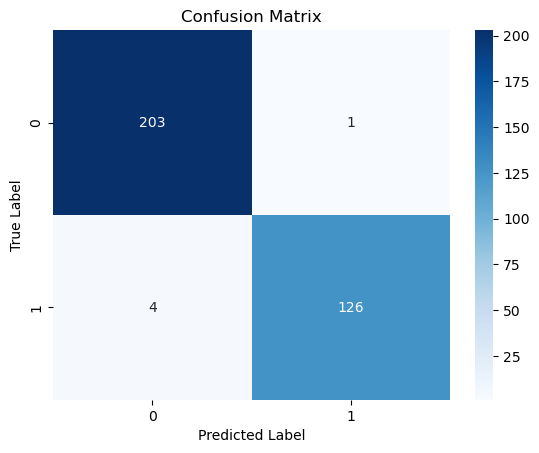

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true are your actual labels and y_pred are your predicted labels
cm = confusion_matrix(binary_predictions, jenis_manual)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

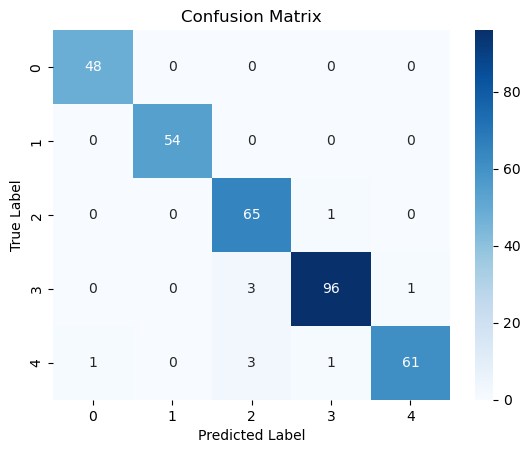

In [10]:
cm = confusion_matrix(category_predictions, warna_manual)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()